## 1. Load Libraries

In [17]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

## 2. Load Data and Feature/Target Selection

I am using Pro Football Focus' 2024 running back dataset from their fantasy football dashboard. This data is compiled by Pro Football Focus and available to paid subscribers. This dataset contains 145 observations with 20 features. Columns including counting stats and expected stats. 

In [18]:
df = pd.read_csv("expected-fantasy-points.csv")

features = ['Receiving Rec', 'Receiving Yds', 'Receiving TD', 'Rushing Yds', 'Rushing TD']
target = 'Fantasy Points Pts'

X = df[features].values
y = df[target].values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

## 3. Train and Test

Setup to initialize and train KNN regressor. 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 20.23
MAE: 11.02


## 4. KNN Regression Plot

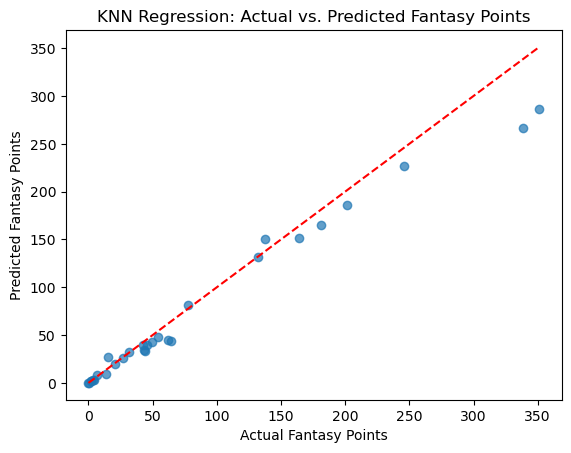

In [20]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Fantasy Points")
plt.ylabel("Predicted Fantasy Points")
plt.title("KNN Regression: Actual vs. Predicted Fantasy Points")
plt.show()

This visual compares actual fantasy point values to the predicted values generated by KNN. Included within the plot is a line of best fit (dashed red line) which shows a perfect fit of actual vs. predicted. In other words, if every fantasy point total was predicted correctly by the KNN model, every blue plotted point would fall exactly along the red dashed line. This plot shows that most of the actual totals were very close to the predicted totals, especially when those totals were lower (<100 points). There is some variance, though, as especially as the totals get larger. Fantasy points between 100 and 300 were a little less accurate to predict, and there is even greater variance for fantasy points between 300 and 350. Since the points fall "below" the best-fit line, we can see that the KNN model often undepredicts the fantasy points associated with high-point performances (elite/best performances). I am not necessarily surprised by this outcome; I would expect that the model has some trouble predicting the high-end point totals because they are somewhat rare and not many to learn from. 

## 5. Hyperparameter Tuning

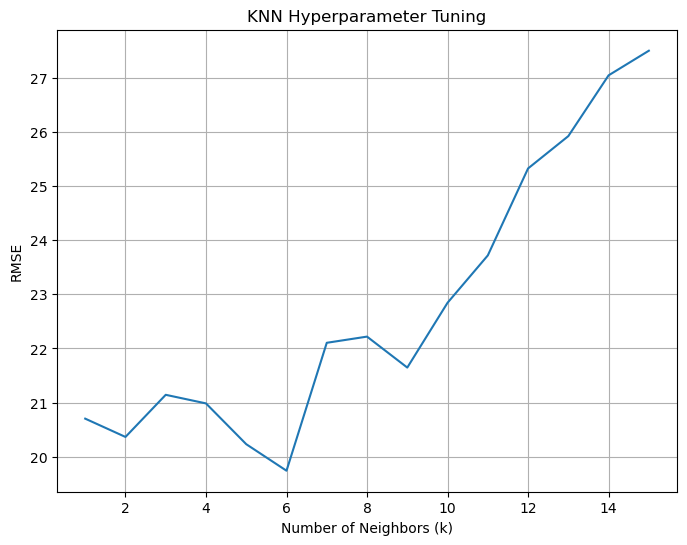

Best number of neighbors (k): 6; RMSE = 19.74


In [21]:
k_values = list(range(1, 16))
rmse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

plt.figure(figsize=(8, 6))
plt.plot(k_values, rmse_values)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("RMSE")
plt.title("KNN Hyperparameter Tuning")
plt.grid(True)
plt.show()

best_k = k_values[np.argmin(rmse_values)]
print(f"Best number of neighbors (k): {best_k}; RMSE = {min(rmse_values):.2f}")

One important component of KNN modeling is to find the optimal number of neighbors, indicated by variable k. Originally, I set the range for k between 1 and 40. However, it became clear that a number as large as 40 was not going to be the best k-value. Then, I shrunk the range from 1 to 15. That still proved to be high, but it offered a much better window into the appropriate range for k. 

The above visual shows that RMSE somewhat decreases as k increases between 1 and 6, with a notable blip in the middle. The best number of neighbors (k) is 6 with an RMSE of 19.74, and for any k greater than 6, the RMSE starts to have a steady increase.

## 6. Residuals Plot

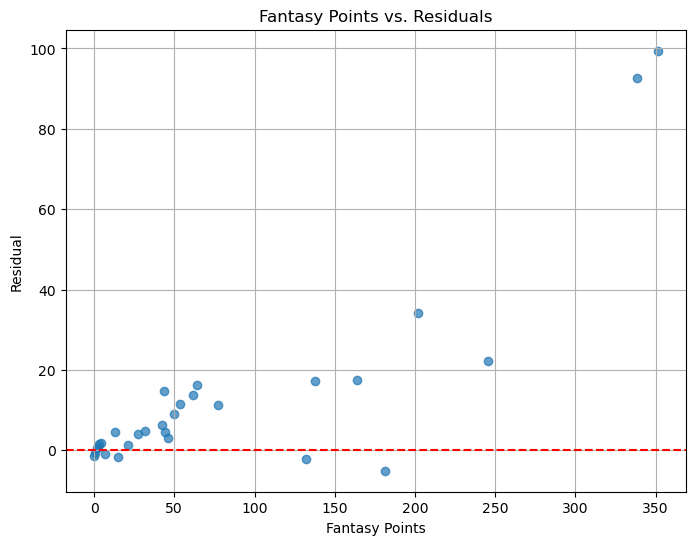

In [22]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fantasy Points")
plt.ylabel("Residual")
plt.title("Fantasy Points vs. Residuals")
plt.grid(True)
plt.show()

The above visual shows the residuals for my exploration into fantasy points. In other words, it plots the difference between actual and predicted fantasy point totals among running backs. This plot does not show the residuals randomly scattered around 0, as desired. Instead, we see that there are more residuals above 0 and less below 0. Additionally, the residuals stray further from the x=0 line (mostly in the positive direction) as the fantasy points total increases. In fact, the two largest residuals correspond to the two largest fantasy point totals. This is not surprising, and it aligns with the comment I made earlier: "I would expect that the model has some trouble predicting the high-end point totals because they are somewhat rare and not many to learn from."

## 7. Attempt on Expected FPTS

After reviewing the above plots, I was curious whether setting a similar yet different target might produce a different outcome. Instead of using actual fantasy points as the target, I used expected points, which is a statistic developed by Pro Football Focus. Their equation for generating this statistic is not abundantly clear, but it is loosely based off a player's performance when you eliminate certain controllable and uncontrollable factors. According to PFF, xFPTS "compares the fantasy points they’ve scored versus what we would have expected based on how they were used and targeted in their offenses."

While I understand there may be flaws between comparing my kNN model's predicted fantasy points to PFF's expected fantasy points, I was still curious about the process and result. I re-ran the entire model from above, except this time, it was with expected fantasy points as the target. The regression plot, hyperparameter tuning, and residuals plot for this second attempt are shown below. 

RMSE: 12.74
MAE: 9.58


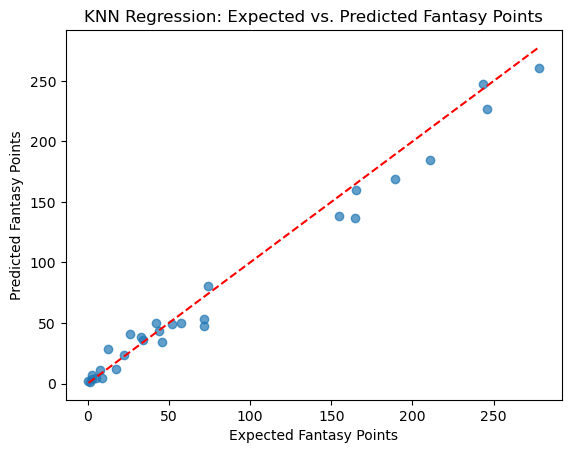

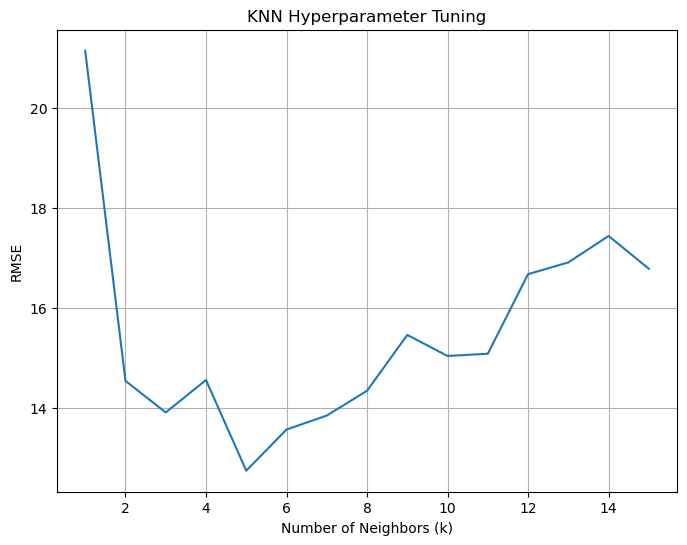

Best number of neighbors (k): 5; RMSE = 12.74


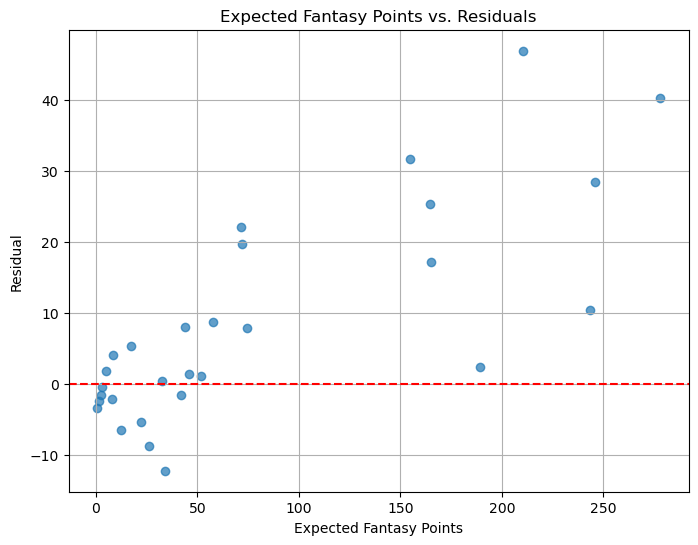

In [23]:
df = pd.read_csv("expected-fantasy-points.csv")

features = ['Receiving Rec', 'Receiving Yds', 'Receiving TD', 'Rushing Yds', 'Rushing TD']
target = 'Fantasy Points x-Pts'

X = df[features].values
y = df[target].values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Expected Fantasy Points")
plt.ylabel("Predicted Fantasy Points")
plt.title("KNN Regression: Expected vs. Predicted Fantasy Points")
plt.show()

k_values = list(range(1, 16))
rmse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

plt.figure(figsize=(8, 6))
plt.plot(k_values, rmse_values)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("RMSE")
plt.title("KNN Hyperparameter Tuning")
plt.grid(True)
plt.show()

best_k = k_values[np.argmin(rmse_values)]
print(f"Best number of neighbors (k): {best_k}; RMSE = {min(rmse_values):.2f}")

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Expected Fantasy Points")
plt.ylabel("Residual")
plt.title("Expected Fantasy Points vs. Residuals")
plt.grid(True)
plt.show()

The biggest difference I notice is that the residuals are scattered even further from the x=0 line here, but the extremes are not as great. In the first example, the largest residual approached x=60. Here, it falls shy of x=50. Still, the residuals continue to following a non-random pattern above 100 fantasy points, with all being greater than zero when fantasy points are between 50 and 300. 